In [1]:
from qiskit import Aer, QuantumRegister, QuantumCircuit, transpile, execute
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.quantum_info import state_fidelity

# Numerical/Stats pack
import pandas as pd
import numpy as np
import scipy.stats as ss
import numpy.linalg as nl
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

# For optimization
from cvxopt import matrix, solvers
from scipy.optimize import minimize_scalar,minimize


from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)
import measfilter as mf
from measfilter import closest_mode, closest_average, dq, findM # package for measurement error filter

# Choose Data Source

In [2]:
# Santiago
n = 2
interested_qubits = [1,2] # Qubit Order
itrs = [1,3,5,10,15,20]
DataFileAddress = 'BellSantiago/'
NoiseFileAddress = 'BellSantiago/'
num_groups = 12*8 # Number of data points

# # Athens
# n = 2
# interested_qubits = [2,3] # Qubit Order
# itrs = [1,3,5,10,15]
# DataFileAddress = 'BellAthens/'
# NoiseFileAddress = 'BellAthens/'
# num_groups = 15*8 # Number of data points

# Read Iterative Circuit Data

In [3]:
def counts_to_probs(counts):
    num_qubits = len(list(counts.keys())[0])
    counts_shots = np.sum([v for v in counts.values()])
    probs = np.zeros(2**(num_qubits), dtype=np.float64)
    for k,v in counts.items():
        probs[int(k,2)] = v/counts_shots
    return probs

In [4]:
# Read Bell State Data
mems = {} # Key is number of iterations
# real_counts = {}  # Key is number of iterations
# real_prob_dists = {} # Key is number of iterations
for itr in itrs:
    mems[itr] = np.load(DataFileAddress+'BellStateItr{:d}.npy'.format(itr))
#     real_counts[itr] = Counter(mems[itr])
#     real_prob_dists[itr] = counts_to_probs(real_counts[itr])
    
mems

{1: array(['00', '00', '00', ..., '00', '00', '00'], dtype='<U2'),
 3: array(['00', '00', '00', ..., '10', '00', '00'], dtype='<U2'),
 5: array(['01', '00', '01', ..., '00', '00', '00'], dtype='<U2'),
 10: array(['00', '01', '00', ..., '00', '11', '00'], dtype='<U2'),
 15: array(['10', '01', '00', ..., '00', '00', '01'], dtype='<U2'),
 20: array(['00', '00', '00', ..., '00', '00', '01'], dtype='<U2')}

# Reconstruct Measurement Error Filter

In [5]:
# Qiskit Filter
state_labels = np.load(NoiseFileAddress+'state_labels.npy')
cal_matrix = np.load(NoiseFileAddress+'cal_matrix.npy')
qis_filter = MeasurementFilter(cal_matrix, state_labels)
qis_filter.cal_matrix

array([[9.57397461e-01, 2.34375000e-02, 2.91748047e-02, 6.10351562e-04],
       [3.34472656e-02, 9.70581055e-01, 1.09863281e-03, 3.06396484e-02],
       [8.91113281e-03, 2.44140625e-04, 9.36767578e-01, 2.83203125e-02],
       [2.44140625e-04, 5.73730469e-03, 3.29589844e-02, 9.40429688e-01]])

In [6]:
# qis_counts = {}
# qis_prob_dists = {}
# for key,val in real_counts.items():
#     qis_counts[key] = qis_filter.apply(val)
#     qis_prob_dists[key] = counts_to_probs(qis_counts[key])
    
# qis_counts, qis_prob_dists

In [7]:
# CB Filter
CB_filter = mf.MeasFilter(interested_qubits[::-1], file_address=NoiseFileAddress)
CB_filter.post_from_file()
# CB_filter.inference(nPrior=60000, Priod_sd=0.1, seed=751, shots_per_point=1024*8)
CB_filter.mean(), CB_filter.mat_mean

({'Qubit2': array([0.94254823, 0.91477865]),
  'Qubit1': array([0.95337446, 0.85289597])},
 array([[0.89860141, 0.13865265, 0.08124786, 0.0125364 ],
        [0.04394682, 0.80389559, 0.00397349, 0.07268495],
        [0.05477305, 0.00845139, 0.8721266 , 0.13456763],
        [0.00267872, 0.04900038, 0.04265205, 0.78021102]]))

In [8]:
# CB_counts = {}
# CB_prob_dists = {}
# for key,val in real_counts.items():
#     CB_counts[key] = CB_filter.filter_mean(val)
#     CB_prob_dists[key] = counts_to_probs(CB_counts[key])
    
# CB_counts, CB_prob_dists

# Read Selected Iterative Circuit Data

In [9]:
def counts_to_probs(counts):
    num_qubits = len(list(counts.keys())[0])
    counts_shots = np.sum([v for v in counts.values()])
    probs = np.zeros(2**(num_qubits), dtype=np.float64)
    for k,v in counts.items():
        probs[int(k,2)] = v/counts_shots
    return probs

# Functions
def data_division(data, num_groups):
    groups = np.split(data, num_groups)
    group_counts = []
#     group_dists = np.zeros((2**len(data[0]), num_groups),dtype=np.float64)
    for i in range(num_groups):
        group_count = Counter(groups[i])
        group_counts.append(group_count)
#         group_dists[:,i] = counts_to_probs(group_count)
        
    return group_counts

In [10]:
selected_itr = 5 # Select a number of iterations from itrs in the first section

select_readouts = mems[selected_itr]
dists_data = data_division(select_readouts, num_groups)
dists_data
# dists_data, dists_data.sum(axis=0), len(dists_data.sum(axis=0))

[Counter({'01': 41, '00': 913, '10': 56, '11': 14}),
 Counter({'00': 911, '01': 51, '11': 12, '10': 50}),
 Counter({'00': 903, '01': 51, '11': 19, '10': 51}),
 Counter({'00': 885, '01': 49, '10': 71, '11': 19}),
 Counter({'00': 907, '11': 17, '10': 47, '01': 53}),
 Counter({'00': 891, '11': 24, '10': 57, '01': 52}),
 Counter({'00': 889, '01': 57, '10': 51, '11': 27}),
 Counter({'00': 877, '01': 55, '10': 68, '11': 24}),
 Counter({'00': 898, '10': 48, '01': 56, '11': 22}),
 Counter({'00': 893, '11': 18, '10': 56, '01': 57}),
 Counter({'00': 897, '11': 25, '01': 53, '10': 49}),
 Counter({'00': 906, '01': 51, '10': 48, '11': 19}),
 Counter({'00': 903, '01': 54, '11': 17, '10': 50}),
 Counter({'00': 877, '01': 68, '11': 28, '10': 51}),
 Counter({'00': 889, '11': 27, '10': 44, '01': 64}),
 Counter({'00': 878, '01': 56, '10': 56, '11': 34}),
 Counter({'00': 902, '10': 45, '01': 56, '11': 21}),
 Counter({'00': 898, '01': 47, '10': 62, '11': 17}),
 Counter({'10': 63, '00': 898, '01': 52, '11':

# Find VD Data

In [11]:
def VD(p,q):
    np_p = np.array(p)
    np_q = np.array(q)
    return 0.5*np.abs(np_p - np_q).sum()


def one_itr(qc):
    qc.h(0)
    qc.cx(0,1)
    qc.barrier()
    qc.cx(0,1)
    qc.h(0)
    qc.barrier()

# Bell0 state
def pure_circuit(name=None):
    r = QuantumRegister(n)
    qc = QuantumCircuit(r, name=name)
    for it in range(itr):
        one_itr(qc)
    return r, qc  

def noise_gates_circuit(noise_params):
    angles = noise_params.reshape((3, n)) #NOT A NUMPY ARRAY FROM SCIPY.OPTIMIZE
    
    r = QuantumRegister(n)
    qc = QuantumCircuit(r)
    for it in range(itr):
        one_itr(qc)
        for q in range(n):
            qc.u(angles[0,n-q-1], angles[1,n-q-1], angles[2,n-q-1], n-q-1) # Add noise/denoise here
        qc.barrier()
    return r, qc

In [12]:
true_r, true_qc = pure_circuit()
true_state = Statevector.from_instruction(true_qc)
true_prob = true_state.probabilities()

VD_data_real = np.array([VD(counts_to_probs(dists_data[g]), true_prob) for g in range(num_groups)])
VD_data_qis = np.array([VD(counts_to_probs(qis_filter.apply(dists_data[g])), true_prob) for g in range(num_groups)])
VD_data_CB = np.array([VD(counts_to_probs(CB_filter.filter_mean(dists_data[g])), true_prob) for g in range(num_groups)])

VD_data_real.shape, VD_data_real, VD_data_qis.shape, VD_data_qis, VD_data_CB.shape, VD_data_CB

((96,),
 array([0.10839844, 0.11035156, 0.11816406, 0.13574219, 0.11425781,
        0.12988281, 0.13183594, 0.14355469, 0.12304687, 0.12792969,
        0.12402344, 0.11523437, 0.11816406, 0.14355469, 0.13183594,
        0.14257812, 0.11914062, 0.12304687, 0.12304687, 0.11425781,
        0.125     , 0.12890625, 0.13085937, 0.14453125, 0.11816406,
        0.10742187, 0.11132812, 0.1171875 , 0.11425781, 0.12792969,
        0.12988281, 0.140625  , 0.12597656, 0.11132812, 0.10351562,
        0.12011719, 0.12792969, 0.1328125 , 0.11816406, 0.14257812,
        0.10449219, 0.12304687, 0.12695312, 0.13085937, 0.11523437,
        0.11914062, 0.12011719, 0.140625  , 0.09960937, 0.11816406,
        0.1015625 , 0.12207031, 0.12695312, 0.11523437, 0.1484375 ,
        0.13769531, 0.11132812, 0.12109375, 0.13476562, 0.11035156,
        0.12988281, 0.12597656, 0.13476562, 0.15527344, 0.11425781,
        0.12792969, 0.12890625, 0.14453125, 0.11230469, 0.13671875,
        0.13867187, 0.14550781, 0.133789

# Inference

(Old) $|x_{t+1}\rangle = U|x_t\rangle + \xi$, where $U = I$, $\sigma \in R$, $\xi \in R^4$ a random $N(\mu,\sigma^2)$ vector. The model parameter are $\mu, \sigma$.

$|x_{t+1}\rangle = U|x_t\rangle + \xi$, where $U = I$, $\xi \in R^4$ a random $N(\mu,\sigma^2)$ vector. The model parameter are entries of $\xi$.

In [13]:
def tnorm01(center, sd, size=1):
    """ Generate random numbers for truncated normal with range [0,1]

    Args:
      center: float
        mean of normal distribution
      sd: float
        standard deviation of normal distribution
      size: int
        number of random numbers

    Returns: array
       an array of random numbers
    """
    upper = 2*np.pi
    lower = 0
    a, b = (lower - center) / sd, (upper - center) / sd
    return ss.truncnorm.rvs(a, b, size=size) * sd + center

def find_mode(data):
    """Find the mode through Gaussian KDE.

    Args:
      data: array
        an array of floats

    Returns: float
      the mode.
    """
    kde = ss.gaussian_kde(data)
    line = np.linspace(min(data), max(data), 10000)
    return line[np.argmax(kde(line))]


def closest_mode(post_lambdas):
    """Find the tuple of model parameters that closed to 
       the Maximum A Posteriori (MAP) of 
       posterior distribution of each parameter

    Args:
      post_lambdas: numpy array
        an m-by-n array where n is the number of posteriors and m is number 
        of parameters in the model

    Returns: numpy array
      an array that contains the required model parameters.
    """

    mode_lam = []
    for j in range(post_lambdas.shape[0]):
        mode_lam.append(find_mode(post_lambdas[j]))

    sol = np.array([])
    smallest_norm = nl.norm(post_lambdas[1])
    mode_lam = np.array(mode_lam)
    for k in range(post_lambdas.shape[1]):
        lam = post_lambdas[:,k]
        norm_diff = nl.norm(lam - mode_lam)
        if norm_diff < smallest_norm:
            smallest_norm = norm_diff
            sol = lam
    return sol


def closest_average(post_lambdas):
    """Find the tuple of model parameters that closed to 
       the mean of posterior distribution of each parameter

    Args:
      post_lambdas: numpy array
        an n-by-m array where n is the number of posteriors and m is number 
        of parameters in the model

    Returns: numpy array
      an array that contains the required model parameters.
    """
    sol = np.array([])
    smallest_norm = nl.norm(post_lambdas[1])

    ave_lam = np.mean(post_lambdas, axis=1)

    for k in range(post_lambdas.shape[1]):
        lam = post_lambdas[:,k]
        norm_diff = nl.norm(lam - ave_lam)

        if norm_diff < smallest_norm:
            smallest_norm = norm_diff
            sol = lam
    return sol


def QoI(prior_lambdas, true_prob):
    """
    Function equivalent to Q(lambda) in https://doi.org/10.1137/16M1087229

    Parameters
    ----------
    prior_lambdas : numpy array (num_priors, num_params)
        each subarray is an individual prior lambda.

    Returns
    -------
    qs : numpy array
        QoI's. Here they are the variation distance between simulated circuit output and true prob dist
    """
    # Find number of priors
    num_priors = prior_lambdas.shape[1]
    
    # For each prior, generate its simulation circuit and find the VD between its output
    qs = np.array([], dtype=np.float64)
    for i in range(num_priors):
        x = np.array([1,0,0,0], dtype=np.float64) # Initialize |x_0>
        
        # Compute |x_t>, U is identity so no matrix multiplication
        for it in range(selected_itr):
            xi = prior_lambdas[:,i]
            x = x+xi
        param_prob = np.abs(x)**2/(np.sum(np.abs(x)**2)) # With normalization
        qs = np.append(qs, VD(param_prob, true_prob))
    return qs



def output(d,
           M,
           prior_mean,
           prior_sd,
           true_prob,
           seed=127,
           file_address=''):
    """
      The main function that do all Bayesian inferrence part

    Parameters
    ----------
    d : array
        array of data (Observed QoI). Here, it is variation distance.
    M : int
        Number of priors required.
    prior_mean: array
        length is 3*num_qubits, range from 0 to 2pi
    prior_sd : float
        standard deviation for truncated normal distribution when generating 
        prior parameters (for measurement error).
    seed : int, optional
        Seed for random numbers. The default is 127.
    file_address : String, optional
        The relative file address to save posteriors and figures. 
        Ends with '/' if not empty
        The default is ''.

    Returns
    -------
    prior_lambdas : numpy array
        prior lambdas in the form of a-by-b matrix where 
        a is the number of priors and m is the number of model parameters
    post_lambdas : numpy array
        prior lambdas in the form of a-by-b matrix where 
        a is the number of posterior and m is the number of model parameters

    """
    # Algorithm 1 of https://doi.org/10.1137/16M1087229
    np.random.seed(seed)
    
    # Get distribution of data (Gaussian KDE)
    d_ker = ss.gaussian_kde(d)  # i.e., pi_D^{obs}(q), q = Q(lambda)

    # Sample prior lambdas, assume prior distribution is Normal distribution with mean as the given probality from IBM
    # Absolute value is used here to avoid negative values, so it is little twisted, may consider Gamma Distribution
    num_lambdas = 4
    prior_lambdas = np.zeros(M * num_lambdas).reshape((num_lambdas, M))
    for i in range(M):
        one_sample = np.zeros(num_lambdas)
        for j in range(num_lambdas):
            one_sample[j] = np.random.normal(prior_mean[j], prior_sd[j])
        prior_lambdas[:,i] = one_sample
    
    print("Finish Prior Selection")
    # Produce prior QoI
    qs = QoI(prior_lambdas, true_prob)
    #print(qs)
    qs_ker = ss.gaussian_kde(qs)  # i.e., pi_D^{Q(prior)}(q), q = Q(lambda)

    # Algorithm 2 of https://doi.org/10.1137/16M1087229

    # Find the max ratio r(Q(lambda)) over all lambdas
    max_r, max_q = findM(qs_ker, d_ker)
    # Print and Check
    print('Final Accepted Posterior Lambdas')
    print('M: %.6g Maximizer: %.6g pi_obs = %.6g pi_Q(prior) = %.6g' %
          (max_r, max_q, d_ker(max_q), qs_ker(max_q)))

    post_lambdas = np.array([])
    # Go to Rejection Iteration
    for p in range(M):
        # Monitor Progress
        print('Progress: {:.3%}'.format(p/M), end='\r')
        
        r = d_ker(qs[p]) / qs_ker(qs[p])
        eta = r / max_r
        if eta > np.random.uniform(0, 1, 1):
            post_lambdas = np.append(post_lambdas, prior_lambdas[:,p])
    print()
    
    
    post_lambdas = post_lambdas.reshape(num_lambdas, int(post_lambdas.size / num_lambdas), order='F')  # Reshape since append destory subarrays
    post_qs = QoI(post_lambdas, true_prob)
    post_ker = ss.gaussian_kde(post_qs)

    xs = np.linspace(0, 1, 1000)

    I = 0
    for i in range(xs.size - 1):
        q = xs[i]
        if qs_ker(q) > 0:
            r = d_ker(q) / qs_ker(q)
            I += r * qs_ker.pdf(q) * (xs[i + 1] - xs[i])  # Just Riemann Sum

    print('Accepted Number N: %.d, fraction %.3f' %
          (post_lambdas.shape[1], post_lambdas.shape[1] / M))
    print('I(pi^post_Lambda) = %.5g' % (I))  # Need to close to 1
    print('Posterior Lambda Mean', closest_average(post_lambdas))
    print('Posterior Lambda Mode', closest_mode(post_lambdas))
    
    print('0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = %6g' %
          (ss.entropy(post_ker(xs), d_ker(xs))))
    print('0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) = %6g' %
          (ss.entropy(d_ker(xs), post_ker(xs))))

    plt.plot(xs,
             d_ker(xs),
             color='Red',
             linestyle='dashed',
             linewidth=3,
             label='$\\pi^{\\mathrm{obs}}_{\\mathcal{D}}$')
    plt.plot(xs, post_ker(xs), color='Blue', label='$\\pi_{\\mathcal{D}}^{Q(\\mathrm{post})}$')
    plt.xlabel('VD')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(file_address + 'QoI-Add-VD.pdf')
    plt.show()

    return prior_lambdas, post_lambdas

## Real Data

In [27]:
def show_post_info(post_lambdas):
    post_mean = closest_average(post_lambdas)
    print("Post mean", post_mean)

    post_QoI = QoI(post_lambdas, true_prob)
    print("Posterior Mean±sd")
    for i in range(4):
        print("{:.4g}±{:.4g}".format(np.mean(post_lambdas[i]), np.std(post_lambdas[i])))
    print("Post-QoI: mean = {:.4g}, sd = {:.4g}".format(np.mean(post_QoI), np.std(post_QoI)))

    fig, axs = plt.subplots(1,5)

    sns.kdeplot(data=post_QoI, ax = axs[0])
    axs[0].set_xlabel(r"VD")
    axs[0].set_title(r"Post-QoI")
    
    sns.kdeplot(data=post_lambdas[0], ax = axs[1])
#     axs[1].set_xlabel(r"$\mu$")
    axs[1].set_title(r"Post 0")
    sns.kdeplot(data=post_lambdas[1], ax = axs[2])
#     axs[2].set_xlabel(r"$\sigma$")
    axs[2].set_title(r"Post 1")
    sns.kdeplot(data=post_lambdas[2], ax = axs[3])
#     axs[3].set_xlabel(r"$\mu$")
    axs[3].set_title(r"Post 2")
    sns.kdeplot(data=post_lambdas[3], ax = axs[4])
#     axs[4].set_xlabel(r"$\sigma$")
    axs[4].set_title(r"Post 3")
    plt.show()

Finish Prior Selection


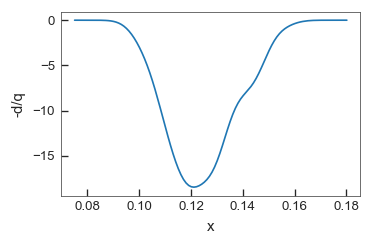

Final Accepted Posterior Lambdas
M: 18.4655 Maximizer: 0.121081 pi_obs = 30.2092 pi_Q(prior) = 1.63598
Progress: 99.999%
Accepted Number N: 5488, fraction 0.055
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.08077672 0.06854332 0.05315051 0.02808145]
Posterior Lambda Mode [0.12691458 0.06960543 0.06453585 0.05725254]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00106745
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


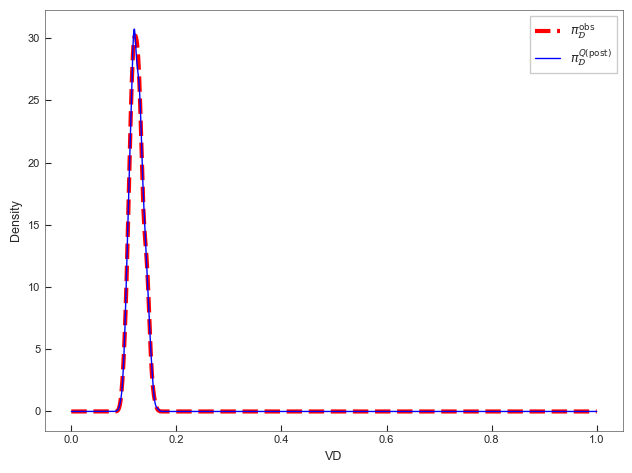

Post mean [0.08077672 0.06854332 0.05315051 0.02808145]
Post-mu: mean = -0.01216, sd = 0.1473
Post-sigma: mean = 0.04903, sd = 0.03324
Post-QoI: mean = 0.1247, sd = 0.01268


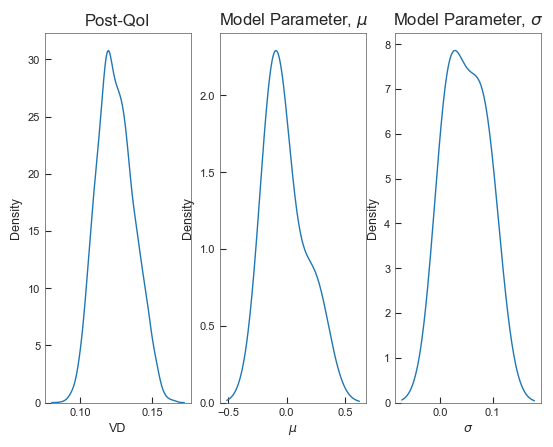

In [15]:
d = VD_data_real
M = 100000
prior_mean = [0.05]*4
prior_sd = [0.1]*4

prior_lambdas_real, post_lambdas_real = output(d, M, prior_mean, prior_sd, true_prob, seed=881, file_address=DataFileAddress)
show_post_info(post_lambdas_real)

Post mean [0.08077672 0.06854332 0.05315051 0.02808145]
Posterior Mean±sd
0.1169±0.08193
0.02323±0.06764
0.02262±0.06784
0.02439±0.06645
Post-QoI: mean = 0.1247, sd = 0.01268


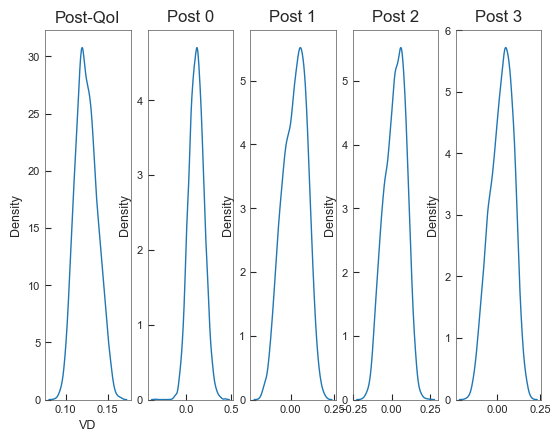

In [28]:
show_post_info(post_lambdas_real)

# Qiskit filtered

Finish Prior Selection


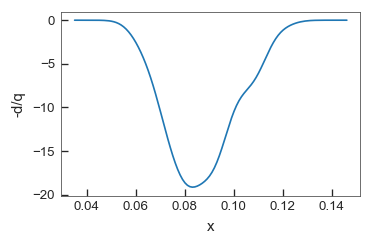

Final Accepted Posterior Lambdas
M: 19.1484 Maximizer: 0.0832264 pi_obs = 28.1689 pi_Q(prior) = 1.47108
Progress: 99.999%
Accepted Number N: 5361, fraction 0.054
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.10567808 0.06795284 0.02338996 0.01939987]
Posterior Lambda Mode [0.12216157 0.03886421 0.05564023 0.05159138]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00104412
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


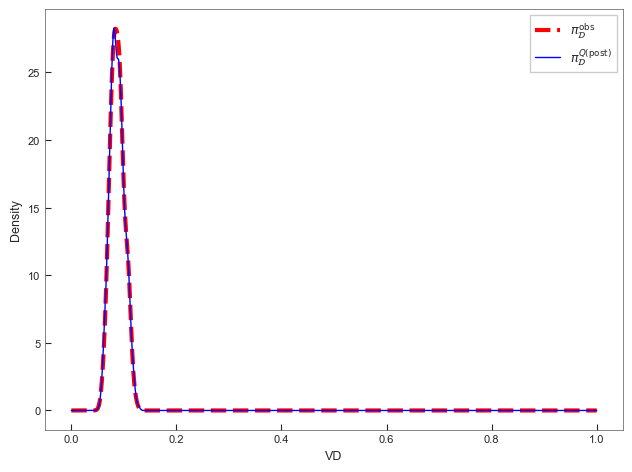

Post mean [0.10567808 0.06795284 0.02338996 0.01939987]
Posterior Mean±sd
0.1248±0.08521
0.01735±0.05756
0.01788±0.05728
0.01726±0.05736
Post-QoI: mean = 0.08742, sd = 0.0136


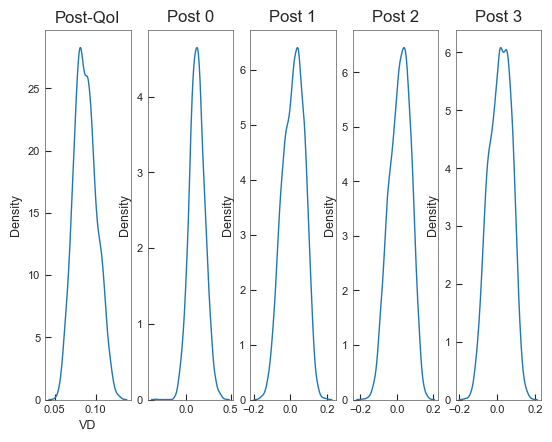

In [29]:
d = VD_data_qis

prior_lambdas_qis, post_lambdas_qis = output(d, M, prior_mean, prior_sd, true_prob, seed=881, file_address=DataFileAddress)
show_post_info(post_lambdas_qis)

# CB Filtered

Finish Prior Selection


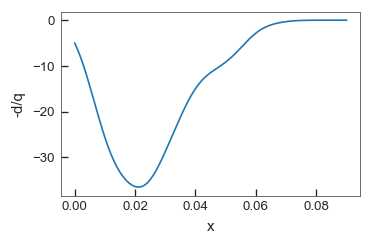

Final Accepted Posterior Lambdas
M: 36.4926 Maximizer: 0.021125 pi_obs = 27.6306 pi_Q(prior) = 0.757157
Progress: 99.999%
Accepted Number N: 3024, fraction 0.030
I(pi^post_Lambda) = 0.99587
Posterior Lambda Mean [0.14834868 0.00500498 0.00313571 0.00936078]
Posterior Lambda Mode [ 0.13316262 -0.00101548  0.01008095  0.02350982]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00467302
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


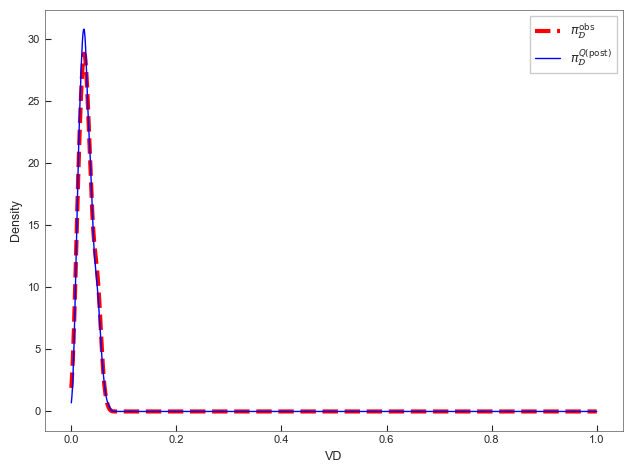

Post mean [0.14834868 0.00500498 0.00313571 0.00936078]
Posterior Mean±sd
0.1365±0.08607
0.006689±0.03401
0.005857±0.03398
0.005812±0.03404
Post-QoI: mean = 0.02886, sd = 0.01338


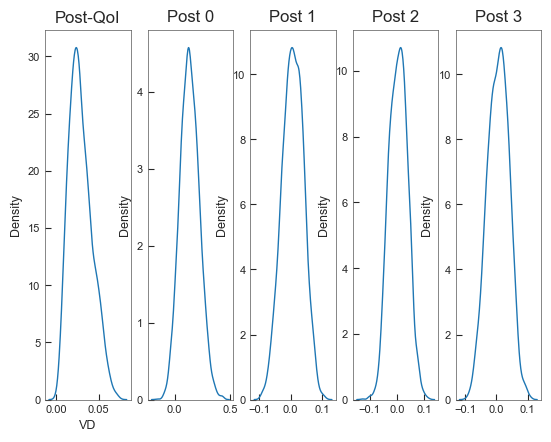

In [30]:
d = VD_data_CB

prior_lambdas_CB, post_lambdas_CB = output(d, M, prior_mean, prior_sd, true_prob, seed=881, file_address=DataFileAddress)
show_post_info(post_lambdas_CB)